In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack

from scipy.interpolate import interp2d
sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

In [4]:
TIGRESS = '/tigress/jiaxuanl/Data/HSC/LSBG'

We study the completeness of LSBG detection. 

The completeness is a product of 1) Johnny's detection completeness matrix; 2) completeness of vanilla scarlet (deblending step). The measurement error of the deblending step is taken care later.

We obtain the completeness matrix of (2) by injecting mock LSBGs (all Sersics).

### 1. Johnny's completeness map for detection

In [5]:
from scipy.interpolate import interp1d, interp2d
from scipy.stats import binned_statistic, binned_statistic_2d

In [8]:
bin_num = [15, 15]
_range = [[2, 15], [24, 29]]
_extent = [item for sublist in _range for item in sublist]

[1.25, 20.75, 23.0, 28.5]


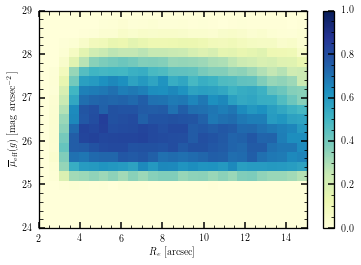

In [10]:
x = np.loadtxt(f'./Catalog/completeness/Greco_completeness_S16A/completeness-x.txt')
y = np.loadtxt(f'./Catalog/completeness/Greco_completeness_S16A/completeness-y.txt')
greco_comp_map = np.loadtxt(f'./Catalog/completeness/Greco_completeness_S16A/completeness.txt') / 100

# 2d interpolation
f_greco = interp2d(x, y, greco_comp_map)

plt.imshow(greco_comp_map, 
           extent=_extent,
#            extent=[min(x), max(x), min(y), max(y)], 
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=1)

plt.xlabel(r'$R_{e}$ [arcsec]')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
plt.colorbar()

print([min(x), max(x), min(y), max(y)])

## Analyze mock gals

### The effect of deblending (vanilla scarlet) -> completeness term

In reality, there are two cuts: one using the vanilla scarlet which dominates the completeness, and the other one using Spergel scarlet (which removes super small and super large ones). 

In [11]:
obj_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_0_5000.fits')[:5000]

# Running vanilla scarlet
method = 'vanilla'
files = [
    f'./Catalog/mock_sample/{method}/_lsbg_meas_{method}_monotonic_{method}_{start*500}_{start*500+500}_nosegmap.fits' 
    for start in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
meas_cat = vstack([Table.read(file) for file in files])

files = [
    f'./Catalog/mock_sample/{method}/_lsbg_meas_{method}_monotonic_{method}_{start*500}_{start*500+500}_segmap.fits' 
    for start in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
seg_meas_cat = vstack([Table.read(file) for file in files])

method = 'spergel'
files = [
    f'./Catalog/mock_sample/{method}/_lsbg_meas_{method}_monotonic_{method}_{start*500}_{start*500+500}_nosegmap.fits' 
    for start in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
]
spergel_cat = vstack([Table.read(file) for file in files])

params_cat = Table.read('./Catalog/mock_sample/mock_gal_param_truth_0_5000.fits')

print('Total number of objects:', len(obj_cat))

bad_flag = (~obj_cat['image_flag'].data).any(axis=1)
bad_flag |= np.isnan(meas_cat['rhalf_circularized'])

obj_cat = obj_cat[~bad_flag]
params_cat = params_cat[~bad_flag]
meas_cat = meas_cat[~bad_flag]
seg_meas_cat = seg_meas_cat[~bad_flag]
spergel_cat = spergel_cat[~bad_flag]
print('Number of survived objs after modeling and file flag:', len(obj_cat))

Total number of objects: 5000
Number of survived objs after modeling and file flag: 4918


In [12]:
# udg_cat = Table.read(f'{TIGRESS}/Catalog/nsa_z002_004/UDG_NSA_MW_z002_004_new.fits')

The purpose of this "deblending" step is to remove junks as much as possible. We generated mock Sersics (n=1) which should not be removed in this step. Therefore, we first run vanilla scarlet on mock galaxies, then apply cuts to them based on the output catalog of vanilla scarlet. Apparently, some of the mock gals will be removed in this way. Then we calculate the fraction of removed galaxies. 

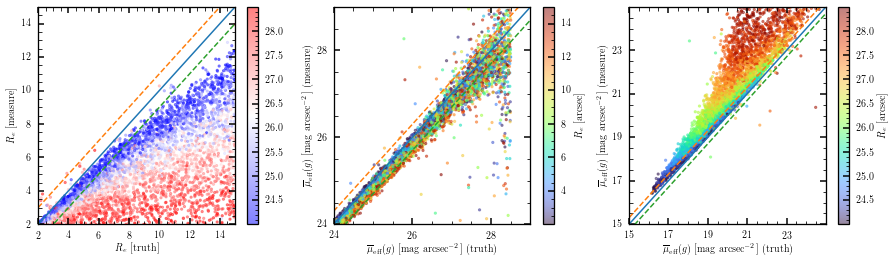

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

re_meas = meas_cat['rhalf_circularized'].data * 0.168 
re_truth =  params_cat['rhalf_circularized'].data

SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data

# compare R_e
plt.sca(axes[0])
plt.scatter(re_truth, re_meas, c=SB_truth, 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

# compare SB_eff
plt.sca(axes[1])
SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data

plt.scatter(SB_truth, SB_meas, c=re_truth, s=5, alpha=0.5)
x = np.linspace(24, 29, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')
plt.colorbar(label=r'$R_e$ [arcsec]')
plt.xticks(ticks=np.arange(24, 29, 2))
plt.yticks(ticks=np.arange(24, 29, 2))
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (truth)')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

plt.xlim(24, 29)
plt.ylim(24, 29)


# Compare total magnitude
plt.sca(axes[2])
mag_meas = meas_cat['mag'].data[:, 0]
mag_truth = params_cat['mag_g'].data

plt.scatter(mag_truth, mag_meas, c=SB_truth, s=5, alpha=0.5)
x = np.linspace(15, 25, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')
plt.colorbar(label=r'$R_e$ [arcsec]')
plt.xticks(ticks=np.arange(15, 25, 2))
plt.yticks(ticks=np.arange(15, 25, 2))
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (truth)')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

plt.xlim(15, 25)
plt.ylim(15, 25)

plt.subplots_adjust(wspace=0.2)

In [14]:
from sample_cuts import make_cuts_vanilla, make_cuts_spergel, post_process_cat_new
import kuaizi
from kuaizi.display import plot_measurement
import pickle
from astropy.cosmology import Planck15
cosmos = Planck15
h = cosmos.h
# kuaizi.set_matplotlib(style='default', usetex=False)

In [15]:
mask = make_cuts_vanilla(obj_cat, meas_cat)
mask &= make_cuts_spergel(spergel_cat)

In [16]:
np.sum(mask)

3556

In [17]:
bin_num = [15, 15]
_range = [[2, 15], [24, 29]]
_extent = [item for sublist in _range for item in sublist]

In [18]:
res_truth = binned_statistic_2d(
    params_cat['rhalf_circularized'].data,
    params_cat['SB_eff_g'].data,
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

res_truth_cuts = binned_statistic_2d(
    params_cat['rhalf_circularized'].data[mask],
    params_cat['SB_eff_g'].data[mask],
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

res_meas = binned_statistic_2d(
    meas_cat['rhalf_circularized'].data * 0.168,
    meas_cat['SB_eff_avg'].data[:, 0],
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

res_meas_cuts = binned_statistic_2d(
    meas_cat['rhalf_circularized'].data[mask] * 0.168,
    meas_cat['SB_eff_avg'].data[:, 0][mask],
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

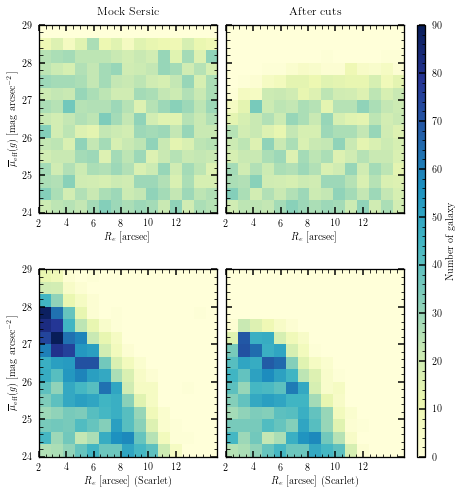

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharey=True, sharex=False)

# In original size
plt.sca(axes[0, 0])
plt.imshow(res_truth.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=90)

plt.sca(axes[0, 1])
plt.imshow(res_truth_cuts.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=90)

# In measured size
plt.sca(axes[1, 0])
plt.imshow(res_meas.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=90)

plt.sca(axes[1, 1])
im = plt.imshow(res_meas_cuts.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=90)
# plt.scatter(udg_cat['rhalf_circularized'].data * 0.168,
#             udg_cat['SB_eff_avg'][:, 0].data, color='salmon', alpha=0.7)

for ax in axes.ravel().tolist():
    ax.set_xlim(_range[0])
    ax.set_ylim(_range[1])
    ax.set_xticks(np.arange(2, 13, 2))
    ax.set_xlabel(r'$R_e$ [arcsec]')
for ax in axes[1]:
    ax.set_xlabel(r'$R_e$ [arcsec] (Scarlet)')
for ax in axes[:, 0]:
    ax.set_ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

axes[0, 0].set_title('Mock Sersic')
axes[0, 1].set_title('After cuts')


# # CBAR
fig.subplots_adjust(right=0.97, bottom=0, top=1)
cbar_ax = fig.add_axes([1.0, 0., 0.02, 1])
fig.colorbar(im, cax=cbar_ax, label='Number of galaxy')

plt.subplots_adjust(wspace=0.05, hspace=0.3)

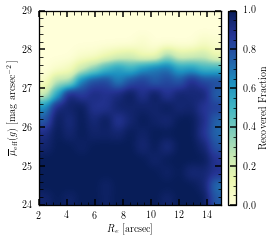

In [20]:
fig, ax = plt.subplots(figsize=(3, 2.7))

deblend_map = np.nan_to_num(res_truth_cuts.statistic.T / res_truth.statistic.T, 0, posinf=0)

im = plt.imshow(deblend_map,
           extent=_extent,
                interpolation='gaussian',
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=1)

ax.set_xlim(_range[0])
ax.set_ylim(_range[1])
ax.set_xticks(np.arange(2, 15, 2))

ax.set_xlabel(r'$R_e$ [arcsec]')
ax.set_ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

## CBAR
fig.subplots_adjust(right=0.97, bottom=0, top=1)
cbar_ax = fig.add_axes([1.0, 0., 0.04, 1])
fig.colorbar(im, cax=cbar_ax, label='Recovered Fraction')

plt.subplots_adjust(wspace=0.05, hspace=0.3)

Combine Greco completeness with deblending completeness

In [21]:
from sample_cuts import get_edge_cens

In [22]:
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

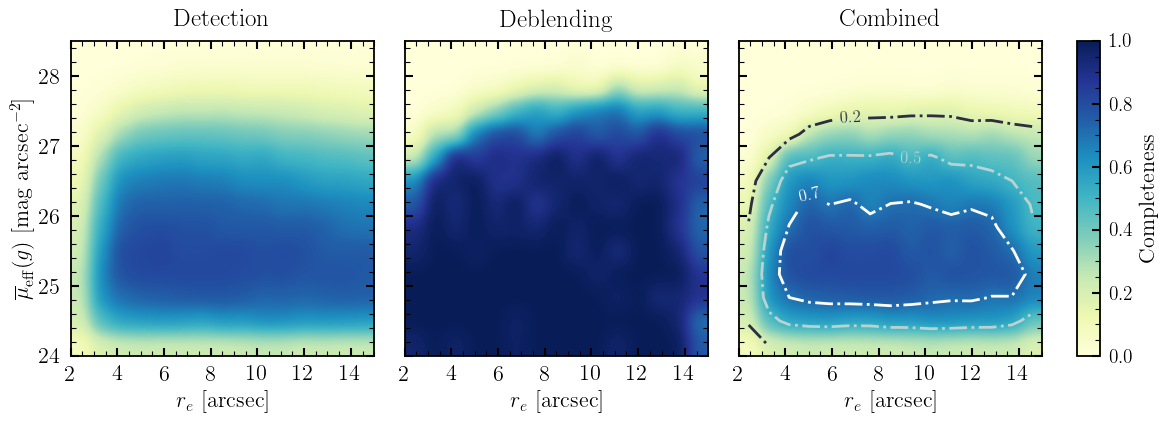

In [23]:
interp = 'gaussian'

deblend_map = np.nan_to_num(res_truth_cuts.statistic.T / res_truth.statistic.T, 0, posinf=0)

# Coarse grid
_x, _y = get_edge_cens([res_truth.x_edge, res_truth.y_edge])
detection_map = f_greco(_x, _y)
# detection_map = np.load('./Catalog/Greco_completeness_S18A/S18A_completeness.npy')

fig, axes = plt.subplots(1, 3, figsize=(11.5, 3.15), sharey=True, sharex=False)

# Greco's detection completeness
plt.sca(axes[0])
plt.imshow(
    detection_map,
    extent=_extent,
    vmin=0, vmax=1, 
    aspect='auto', 
    interpolation=interp,
    cmap='YlGnBu',
    )

# Deblending completeness
plt.sca(axes[1])
im = plt.imshow(deblend_map, 
                extent=_extent, 
                vmin=0, vmax=1, 
                aspect='auto',
                interpolation=interp,
                cmap='YlGnBu')
# plt.scatter(R_e, SB_g, color='r', alpha=0.2)

# Together
plt.sca(axes[2])
plt.imshow(
    detection_map * deblend_map,
    extent=_extent,
    vmin=0, vmax=1, 
    aspect='auto', 
    interpolation=interp,
    cmap='YlGnBu',
    )

from scipy.ndimage import gaussian_filter
temp = gaussian_filter(detection_map * deblend_map, sigma=0.5)
CS = plt.contour(_x, _y, temp, 
                 levels=[0.2, 0.5, 0.7],
                 linewidths=2, linestyles='-.',
                 cmap='bone', vmin=0.1, vmax=0.6, 
                 alpha=1, zorder=10, rasterized=True)
plt.clabel(CS, CS.levels, #fmt='$\sigma=%.2f$',
           inline=True, fontsize=12)


# udg_cat = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_after_viz.fits')
# plt.scatter(udg_cat['rhalf_spergel'].data,
#             udg_cat['SB_eff_avg'][:, 0].data, color='salmon', alpha=0.7)

for ax in axes.ravel().tolist():
    ax.set_xlim(_range[0])
#     ax.set_ylim(_range[1])
    ax.set_ylim(24, 28.5)
    ax.set_xticks(np.arange(2, 15, 2))
    ax.set_xlabel(r'$r_{e}$ [arcsec]')

axes[0].set_ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
axes[0].set_title('Detection', fontsize=18)
axes[1].set_title('Deblending', fontsize=18)
axes[2].set_title('Combined', fontsize=18)


fig.subplots_adjust(right=0.97, bottom=0, top=1)
cbar_ax = fig.add_axes([1.0, 0., 0.02, 1])
cbar = fig.colorbar(im, cax=cbar_ax, label='Completeness')
cbar.ax.tick_params(labelsize=14)

plt.subplots_adjust(wspace=0.1, hspace=0.3)

# plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/completeness.pdf', 
#             dpi=50, bbox_inches='tight')

In [24]:
f_comp = interp2d(_x, _y, detection_map * deblend_map)

In [25]:
import pickle
# save the completeness
with open('./Catalog/completeness/deblend_detection_comp_S16A.pkl', 'wb') as f:
    pickle.dump(f_comp, f)

---

### The effect of modeling (spergel scarlet): please see `measurement_error_implement_new.ipynb`